In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/climate-change_articles_llama_distill.csv")

In [3]:
df.columns

Index(['index', 'interest_slug', 'story_id', 'title', 'description', 'date',
       'url', 'lang', 'paywall', 'source_name', 'source_slug', 'source_bias',
       'source_factuality', 'source_originalBias', 'source_storyCount',
       'source_owners', 'source_biasRatings', 'source_lat', 'source_lon',
       'source_place', 'article_title', 'article_description',
       'article_image_url', 'article_text', 'article_date_publish',
       'article_authors', 'llama_bias', 'score', 'llama_distill_bias',
       'score.1'],
      dtype='object')

In [4]:
df_clean = df[["story_id",
    "title",
    "url",
    "description",
    "date",
    "lang",
    "source_name",
    "source_bias",
    "source_storyCount",
    "article_image_url",
    "llama_distill_bias"]]

# Keep only story_ids with more than 10 articles
df_clean = df_clean.groupby("story_id").filter(lambda x: len(x) > 10)

df_clean

,story_id,title,url,description,date,lang,source_name,source_bias,source_storyCount,article_image_url,llama_distill_bias
14,70464542-20d1-4807-9fed-0a6d9c0df374,Farmers Sue USDA After Agency Deletes Climate ...,https://www.washingtonpost.com/nation/2025/02/...,The lawsuit says the Agriculture Department is...,2025-02-25T13:39:54.000Z,en,The Washington Post,leanLeft,235077,https://www.washingtonpost.com/wp-apps/imrs.ph...,0
15,70464542-20d1-4807-9fed-0a6d9c0df374,"Farmers sue Agriculture Department over ""purge...",https://www.newsweek.com/farmers-sue-agricultu...,Farmers dealing with extreme weather and other...,2025-02-24T23:50:32.000Z,en,Newsweek,center,173892,https://d.newsweek.com/en/full/2594660/farmer-...,0
16,70464542-20d1-4807-9fed-0a6d9c0df374,USDA Faces Lawsuit Over Purge of Climate Chang...,https://www.bloomberg.com/news/articles/2025-0...,The US Department of Agriculture is facing a l...,2025-02-24T19:08:07.000Z,en,Bloomberg,leanLeft,128179,https://www.bloomberg.com/news/articles/2025-0...,1
17,70464542-20d1-4807-9fed-0a6d9c0df374,Farmers sue USDA over deletion of climate data...,https://www.staradvertiser.com/2025/02/24/brea...,Organic farmers and environmental groups sued ...,2025-02-24T22:30:00.000Z,en,Star Advertiser,center,116335,https://www.staradvertiser.com/wp-content/uplo...,0
18,70464542-20d1-4807-9fed-0a6d9c0df374,How an Ontario prof is saving climate change d...,https://www.collingwoodtoday.ca/closer-look/vi...,Tonight on 'Closer Look': With Donald Trump ba...,2025-02-25T00:00:00.000Z,en,Collingwood Today,unknown,64946,https://www.vmcdn.ca/f/files/local2/videos/clo...,0
...,...,...,...,...,...,...,...,...,...,...,...
30109,rss_11054_1732760095408_3,ADB announces appointment of Kanda as next pre...,https://www.bworldonline.com/economy/2024/11/2...,THE Asian Development Bank (ADB) announced Thu...,2024-11-28T13:11:08.000Z,en,bworldonline.com,unknown,4884,https://www.bworldonline.com/wp-content/upload...,2
30110,rss_11054_1732760095408_3,Masato Kanda elected as ADB President - Islama...,https://islamabadpost.com.pk/masato-kanda-elec...,"ISLAMABAD, Nov 28 (APP/DNA):The Asian Developm...",2024-11-28T07:07:44.000Z,en,Islamabad Post,unknown,3887,https://islamabadpost.com.pk/wp-content/upload...,2
30111,rss_11054_1732760095408_3,Masato Kanda Elected as ADB President –...,https://theindianawaaz.com/masato-kanda-electe...,The Asian Development Bank (ADB) Board of Gove...,2024-11-28T10:08:11.000Z,en,theindianawaaz.com,unknown,3128,https://www.newsonair.gov.in/wp-content/upload...,2
30112,rss_11054_1732760095408_3,Masato Kanda elected ADB President,https://dailynewnation.com/masato-kanda-electe...,The Asian Development Bank (ADB) Board of Gove...,2024-11-28T07:40:20.000Z,en,dailynewnation.com,unknown,3077,https://dailynewnation.com/masato-kanda-electe...,2


In [5]:
df_clean.to_csv("data/climate-change_articles_llama_distill_clean.csv", index=False)

## Clustering

In [56]:
import pandas as pd
import numpy as np
from tslearn.metrics import cdist_dtw
from sklearn.cluster import AgglomerativeClustering
from scipy.interpolate import interp1d

In [86]:
import pandas as pd
import numpy as np

# Parameters
NUM_TIMESTEPS = 16

# Example values
values = np.array([0.1, 0.2, -0.1, 0.4, 2])  # Sample bias sequence

# Create accumulated buckets
def accumulated_variance_bins(values, num_bins):
    bin_edges = np.linspace(0, len(values), num_bins + 1, dtype=int)
    accumulated_variances = []

    for i in range(1, num_bins + 1):
        idx_end = bin_edges[i]
        subset = values[:idx_end]
        if len(subset) > 1:
            var = np.var(subset)
        else:
            var = 0.0
        accumulated_variances.append(var)
    
    return np.array(accumulated_variances)

def accumulated_mean_bins(values, num_bins):
    bin_edges = np.linspace(0, len(values), num_bins + 1, dtype=int)
    accumulated_means = []

    for i in range(1, num_bins + 1):
        idx_end = bin_edges[i]
        subset = values[:idx_end]
        if len(subset) > 1:
            mean = np.mean(subset)
        else:
            mean = values[0]
        accumulated_means.append(mean)

    return np.array(accumulated_means)

# Test it
acc_var = accumulated_variance_bins(values, NUM_TIMESTEPS)
print("Accumulated variance per timestep:")
print(np.round(acc_var, 4))


Accumulated variance per timestep:
[0.     0.     0.     0.     0.     0.     0.0025 0.0025 0.0025 0.0156
 0.0156 0.0156 0.0325 0.0325 0.0325 0.5736]


In [87]:
# Load data
df = pd.read_csv("data/climate-change_articles_llama_distill_clean.csv", parse_dates=["date"])

# Map source bias to numeric values
bias_mapping = {
    "farLeft": -3, "left": -2, "leanLeft": -1,
    "center": 0, "unknown": 0,
    "leanRight": 1, "right": 2, "farRight": 3
}
df["source_bias_num"] = df["source_bias"].map(bias_mapping)
df = df.dropna(subset=["llama_distill_bias", "source_bias_num"])

# Parameters
NUM_TIMESTEPS = 16

# Process each story
time_series_list = []
story_ids = []

for story_id, group in df.groupby("story_id"):
    group_sorted = group.sort_values("date")
    values = group_sorted["llama_distill_bias"].to_numpy()
    acc_var = accumulated_variance_bins(values, NUM_TIMESTEPS)
    acc_mean = accumulated_mean_bins(values, NUM_TIMESTEPS)

    time_series_list.append(np.stack([acc_var, acc_mean], axis=1))
    story_ids.append(story_id)

In [94]:
time_series_list[:2]

[array([[0.25      , 1.5       ],
        [0.25      , 1.5       ],
        [0.24489796, 1.42857143],
        [0.22222222, 1.33333333],
        [0.19834711, 1.27272727],
        [0.24489796, 1.42857143],
        [0.25      , 1.5       ],
        [0.24930748, 1.47368421],
        [0.24943311, 1.47619048],
        [0.32514178, 1.39130435],
        [0.38017751, 1.34615385],
        [0.36096939, 1.32142857],
        [0.35555556, 1.33333333],
        [0.54178145, 1.39393939],
        [0.70530612, 1.45714286],
        [0.66481994, 1.42105263]]),
 array([[0.        , 2.        ],
        [0.25      , 1.5       ],
        [0.22222222, 1.33333333],
        [0.1875    , 1.25      ],
        [0.64      , 1.6       ],
        [0.58333333, 1.5       ],
        [0.53061224, 1.57142857],
        [0.4691358 , 1.55555556],
        [0.45      , 1.5       ],
        [0.42975207, 1.54545455],
        [0.41666667, 1.5       ],
        [0.40236686, 1.53846154],
        [0.39285714, 1.5       ],
        [0.5

In [89]:
len(time_series_list)

813

### Elbow

In [ ]:
# Convert to numpy array
X = np.array(time_series_list)

Running k=2
Running k=5
Running k=10
Running k=20
Running k=50


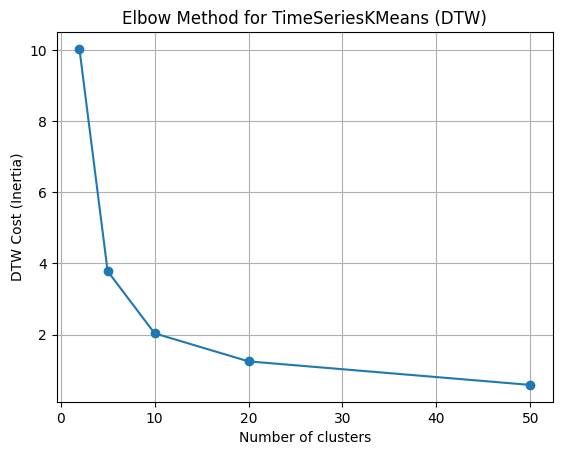

In [92]:
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans

inertias = []
K_range = [2, 5, 10, 20, 50]

for k in K_range:
    print(f"Running k={k}")
    km = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=42, n_jobs=-1)
    km.fit(X)
    inertias.append(km.inertia_)

# Plot elbow
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("DTW Cost (Inertia)")
plt.title("Elbow Method for TimeSeriesKMeans (DTW)")
plt.grid(True)
plt.show()


In [ ]:
# Use time series clustering
from tslearn.clustering import TimeSeriesKMeans

# Time series clustering
km = TimeSeriesKMeans(n_clusters=15, metric="dtw", random_state=42, n_jobs=-1)
y_km = km.fit_predict(X)

# Add cluster labels to dataframe
df_clusters = pd.DataFrame({
    "story_id": story_ids,
    "cluster": y_km
})

df_clusters.value_counts("cluster")

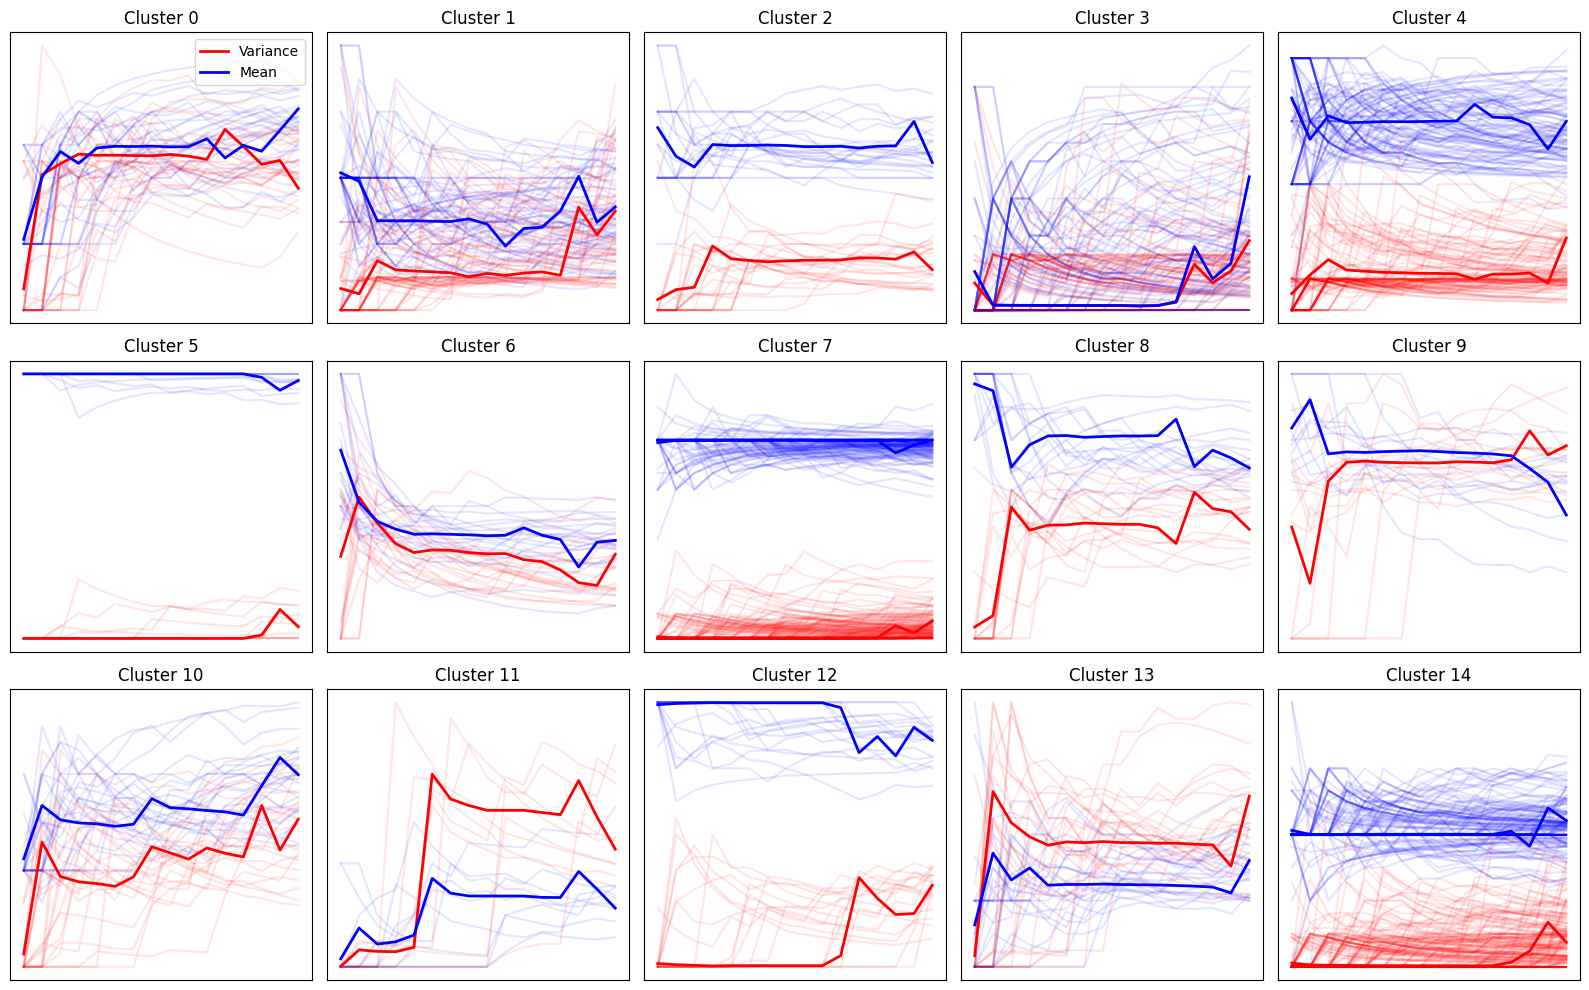

In [105]:
# Visualize clusters
import matplotlib.pyplot as plt
from tslearn.utils import to_time_series_dataset

# Convert to time series dataset
X_ts = to_time_series_dataset(X)

colors = ['r', 'b']  # red for variance, blue for mean

plt.figure(figsize=(16, 10))
for i in range(min(15, km.n_clusters)):
    plt.subplot(3, 5, i + 1)
    
    cluster_series = X_ts[y_km == i]
    
    # Plot each dimension separately
    for ts in cluster_series:
        plt.plot(ts[:, 0], color='r', alpha=0.1)  # variance
        plt.plot(ts[:, 1], color='b', alpha=0.1)  # mean
    
    # Plot cluster center
    plt.plot(km.cluster_centers_[i][:, 0], color='r', lw=2, label='Variance')
    plt.plot(km.cluster_centers_[i][:, 1], color='b', lw=2, label='Mean')

    plt.title(f"Cluster {i}")
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [106]:
# Add cluster labels to original dataframe
df["cluster"] = df["story_id"].map(df_clusters.set_index("story_id")["cluster"])
df.to_csv("data/climate-change_articles_llama_distill_clusters.csv", index=False)